# Analysis
---
This notebook is dedicated to analyzing and visualizing the data that was cleaned and consolidated in the data preprocessing phase (see `prepocessing.ipynb`). A recommendation in response to the business problem outlined below and based on the analysis conducted is included at the bottom of this notebook.

## Business Problem
> Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.

---

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
# Individual cleaned dataframes
df_imdb_title_basics = pd.read_csv('../data/cleaned/df_cleaned_imdb_title_basics.csv')
df_imdb_title_ratings = pd.read_csv('../data/cleaned/df_cleaned_imdb_title_ratings.csv')
df_tn_movie_budgets = pd.read_csv('../data/cleaned/df_cleaned_tn_movie_budgets.csv')

# Consolidated dataframe
df_merged_final = pd.read_csv('../data/cleaned/df_merged_final.csv')

---

## Questions
Answering the following questions will help form and provide evidence for my ultimate recommendation.

### 1. How important are foreign box office results to the overall return on investment?
This question seeks to determine if there is a relationship between the ROI of a movie and how much of its box office revenues came from foreign markets. This is important to determine because a strong correlation would indicate that I should conduct my analysis in the context of how movies perform in foreign markets as being more important than domestic markets. A lack of a relationship would indicate that I can conduct my analysis without needing to adjust for this (such as how different genres perform in different markets).

In [3]:
# Adding columns for ROI and the percent of total revenue that came from foreign box offices
df_foreign = df_merged_final.dropna().copy()
df_foreign['roi'] = (df_foreign['worldwide_gross'] / df_foreign['production_budget']) - 1
df_foreign['foreign_pct'] = df_foreign['foreign_gross'] / df_foreign['worldwide_gross']
df_foreign.head(3)

,tconst,primary_title,original_title,start_year,runtime_minutes,Game-Show,Mystery,Musical,Family,War,...,numvotes,release_date,release_year,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross,roi,foreign_pct
19,tt0249516,Foodfight!,Foodfight!,2012,91.0,0.0,0.0,0.0,0.0,0.0,...,8248.0,"Dec 31, 2012",2012.0,Foodfight!,45000000.0,0.0,73706.0,73706.0,-0.998362,1.000000
48,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,0.0,0.0,0.0,0.0,0.0,...,275300.0,"Dec 25, 2013",2013.0,The Secret Life of Walter Mitty,91000000.0,58236838.0,129624345.0,187861183.0,1.064409,0.690001
52,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,0.0,0.0,0.0,0.0,0.0,...,105116.0,"Sep 19, 2014",2014.0,A Walk Among the Tombstones,28000000.0,26017685.0,36090902.0,62108587.0,1.218164,0.581094


In [4]:
# Previewing the correlation between the two newly added columns
df_foreign[['roi', 'foreign_pct']].corr()

,roi,foreign_pct
roi,1.000000,0.011047
foreign_pct,0.011047,1.000000


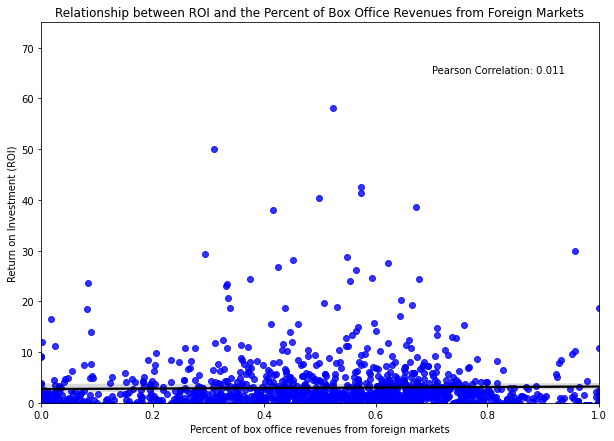

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))

# Styling
ax.set_title('Relationship between ROI and the Percent of Box Office Revenues from Foreign Markets')
ax.set_ylabel('Return on Investment (ROI)')
ax.set_xlabel('Percent of box office revenues from foreign markets')
ax.set_ylim(0, 75)
ax.text(0.70, 65, f"Pearson Correlation: {round(df_foreign[['roi', 'foreign_pct']].corr().iloc[0, 1], 3)}")

# Plotting
sns.regplot(
    x=df_foreign['foreign_pct'].values, 
    y=df_foreign['roi'].values, 
    scatter_kws={'color': 'blue'}, 
    line_kws={'color': 'black'}
);

### 2. Which genres have the highest median return on investment?

In [6]:
genres = df_merged_final.columns[5:32].values
genres

array(['Game-Show', 'Mystery', 'Musical', 'Family', 'War', 'Sport',
       'Reality-TV', 'Short', 'History', 'Adult', 'Western', 'Action',
       'Music', 'Comedy', 'Horror', 'Talk-Show', 'Documentary',
       'Adventure', 'Fantasy', 'Thriller', 'Animation', 'Biography',
       'Crime', 'Romance', 'Sci-Fi', 'News', 'Drama'], dtype=object)

In [7]:
def get_median_roi(genre):
    df_genre = df_merged_final.copy()
    df_genre = df_genre.loc[(df_genre[genre] == 1) & df_genre['worldwide_gross'] > 0]
    df_genre['roi'] = (df_genre['worldwide_gross'] / df_genre['production_budget']) - 1
    return df_genre.roi.median()

In [8]:
# Sorting the data for easier plotting
df_genre_median_roi = pd.DataFrame(
    data=[get_median_roi(genre) for genre in genres],
    columns=['median_roi'],
    index=genres
).dropna().sort_values('median_roi', ascending=False)

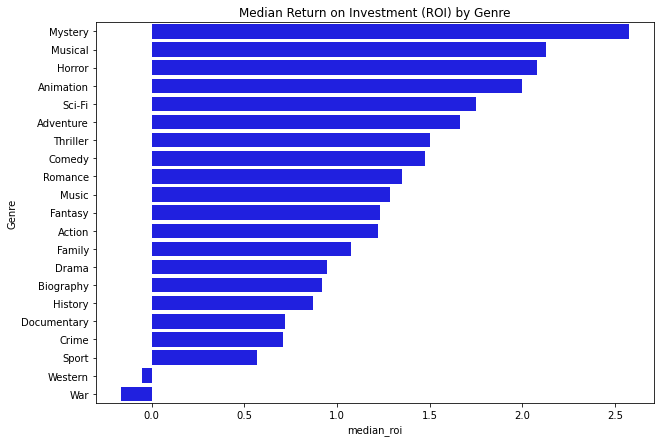

In [9]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Median Return on Investment (ROI) by Genre')
ax.set_ylabel('Genre')
ax.set_xlabel('Median ROI')
sns.barplot(
    x=df_genre_median_roi['median_roi'],
    y=df_genre_median_roi.index,
    orient='h',
    color='blue'
);

### 3. Are there any noticeable trends in the number of movies produced in a particular genre?
The goal of this question is to create a proxy for genre popularity by investigating the change in the amount of movies produced in a particular genre over time. While popularity does not necessarily imply whether or not a particular genre is profitable, this information can be used in conjunction with answers to other questions to evaluate the probability of succes.

To start, I'll whittle down the dataframe to just information regarding the start year and genre.

In [10]:
cols_to_drop = ['primary_title', 'original_title', 'runtime_minutes', 'averagerating', 'numvotes', 
                'release_date', 'release_year', 'movie', 'production_budget', 'domestic_gross', 
                'foreign_gross', 'worldwide_gross']

df_genre_trends = df_merged_final.drop(columns=cols_to_drop)
df_genre_trends.head(3)

,tconst,start_year,Game-Show,Mystery,Musical,Family,War,Sport,Reality-TV,Short,...,Adventure,Fantasy,Thriller,Animation,Biography,Crime,Romance,Sci-Fi,News,Drama
0,tt0063540,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,tt0066787,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,tt0069049,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The dataframe now needs to be pivoted by `start_year`.

In [11]:
df_genre_count_by_year = pd.pivot_table(df_genre_trends, index='start_year', aggfunc='sum')
df_genre_count_by_year

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
start_year,,,,,,,,,,,,,,,,,,,,,
2010,889.0,0.0,500.0,198.0,792.0,2178.0,537.0,4381.0,4290.0,479.0,...,177.0,7.0,847.0,242.0,0.0,185.0,3.0,831.0,140.0,38.0
2011,910.0,0.0,580.0,256.0,889.0,2327.0,570.0,4742.0,4523.0,598.0,...,201.0,0.0,846.0,276.0,1.0,217.0,4.0,908.0,138.0,44.0
2012,915.0,1.0,637.0,243.0,1011.0,2481.0,599.0,5208.0,4792.0,677.0,...,245.0,5.0,869.0,283.0,1.0,219.0,4.0,1016.0,136.0,45.0
2013,1007.0,0.0,791.0,254.0,1252.0,2652.0,716.0,5563.0,5348.0,862.0,...,301.0,9.0,1034.0,355.0,0.0,275.0,4.0,1245.0,119.0,41.0
2014,1072.0,3.0,793.0,280.0,1375.0,2810.0,748.0,5961.0,5475.0,876.0,...,330.0,8.0,1138.0,351.0,0.0,278.0,4.0,1318.0,171.0,63.0
2015,1092.0,2.0,713.0,309.0,951.0,2747.0,737.0,6015.0,5483.0,680.0,...,161.0,19.0,1082.0,388.0,0.0,255.0,11.0,1327.0,170.0,52.0
2016,1207.0,5.0,706.0,301.0,817.0,2852.0,859.0,6054.0,5587.0,594.0,...,57.0,19.0,1073.0,379.0,0.0,275.0,8.0,1394.0,164.0,40.0
2017,1254.0,4.0,671.0,334.0,744.0,2788.0,776.0,6124.0,5609.0,578.0,...,39.0,15.0,975.0,422.0,4.0,234.0,2.0,1370.0,161.0,54.0
2018,1127.0,9.0,616.0,338.0,590.0,2833.0,730.0,5294.0,5620.0,566.0,...,29.0,11.0,982.0,389.0,5.0,199.0,7.0,1485.0,143.0,59.0


This data was likely gathered some time in 2019 given the sharp drop in the number of movies during that year with no apparent reason (unlike a year such as 2020 where the impact of COVID-19 may have been a cause for the decline). As a result, only the rows with a `start_year` less than or equal to 2018 will be kept for analysis.

In [12]:
df_genre_count_by_year = df_genre_count_by_year.loc[df_genre_count_by_year.index <= 2018]
df_genre_count_by_year

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
start_year,,,,,,,,,,,,,,,,,,,,,
2010,889.0,0.0,500.0,198.0,792.0,2178.0,537.0,4381.0,4290.0,479.0,...,177.0,7.0,847.0,242.0,0.0,185.0,3.0,831.0,140.0,38.0
2011,910.0,0.0,580.0,256.0,889.0,2327.0,570.0,4742.0,4523.0,598.0,...,201.0,0.0,846.0,276.0,1.0,217.0,4.0,908.0,138.0,44.0
2012,915.0,1.0,637.0,243.0,1011.0,2481.0,599.0,5208.0,4792.0,677.0,...,245.0,5.0,869.0,283.0,1.0,219.0,4.0,1016.0,136.0,45.0
2013,1007.0,0.0,791.0,254.0,1252.0,2652.0,716.0,5563.0,5348.0,862.0,...,301.0,9.0,1034.0,355.0,0.0,275.0,4.0,1245.0,119.0,41.0
2014,1072.0,3.0,793.0,280.0,1375.0,2810.0,748.0,5961.0,5475.0,876.0,...,330.0,8.0,1138.0,351.0,0.0,278.0,4.0,1318.0,171.0,63.0
2015,1092.0,2.0,713.0,309.0,951.0,2747.0,737.0,6015.0,5483.0,680.0,...,161.0,19.0,1082.0,388.0,0.0,255.0,11.0,1327.0,170.0,52.0
2016,1207.0,5.0,706.0,301.0,817.0,2852.0,859.0,6054.0,5587.0,594.0,...,57.0,19.0,1073.0,379.0,0.0,275.0,8.0,1394.0,164.0,40.0
2017,1254.0,4.0,671.0,334.0,744.0,2788.0,776.0,6124.0,5609.0,578.0,...,39.0,15.0,975.0,422.0,4.0,234.0,2.0,1370.0,161.0,54.0
2018,1127.0,9.0,616.0,338.0,590.0,2833.0,730.0,5294.0,5620.0,566.0,...,29.0,11.0,982.0,389.0,5.0,199.0,7.0,1485.0,143.0,59.0


Genres with zero movies produced in 2010 present an issue since growth between then and 2018 cannot be calculated without running into a division by zero error. Since these genres have very few movies produced in any given year anyways, they can be dropped.

In [13]:
cols_to_drop = [col for col in df_genre_count_by_year.columns if df_genre_count_by_year[col][2010] == 0]
cols_to_drop

['Adult', 'Game-Show', 'Short']

In [14]:
df_genre_count_by_year = df_genre_count_by_year.drop(columns=cols_to_drop)

In [15]:
def get_pct_chg(genre):
    if df_genre_count_by_year[genre][2010] > 0:
        return round(((df_genre_count_by_year[genre][2018] / df_genre_count_by_year[genre][2010]) - 1) * 100, 2)

In [16]:
# Sorting the data for easier plotting
df_genre_pct_chg = pd.DataFrame(
    data=[get_pct_chg(col) for col in df_genre_count_by_year.columns],
    columns=['Pct_Chg'],
    index=df_genre_count_by_year.columns
).sort_values('Pct_Chg', ascending=False)

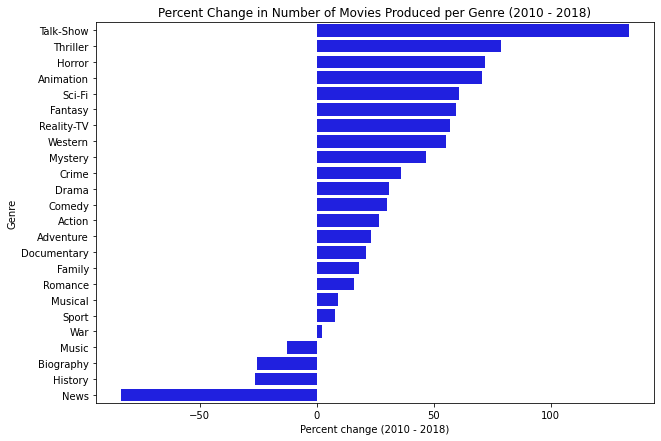

In [17]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Percent Change in Number of Movies Produced per Genre (2010 - 2018)')
ax.set_ylabel('Genre')
ax.set_xlabel('Percent change (2010 - 2018)')
sns.barplot(
    x=df_genre_pct_chg['Pct_Chg'].values,
    y=df_genre_pct_chg.index,
    orient='h',
    color='blue'
);

### 4. What months have the highest median return on investment?
This question helps determine the timing of when to release a movie. Targeting months in which the median ROI of movies is the highest may lead to a higher probability of success.

To answer this question, I must first create a new column that derives the month from the `release_date` column.

In [22]:
df_release_dates = df_merged_final[['release_date', 'production_budget', 'worldwide_gross']].dropna()
df_release_dates['roi'] = (df_release_dates['worldwide_gross'] / df_release_dates['production_budget']) - 1

months = lambda x: int(datetime.strptime(x, '%b %d, %Y').strftime('%m'))
df_release_dates.insert(loc=1, column='month', value=df_release_dates['release_date'].apply(months))

df_release_dates.head()

,release_date,month,production_budget,worldwide_gross,roi
19,"Dec 31, 2012",12,45000000.0,7.370600e+04,-0.998362
48,"Dec 25, 2013",12,91000000.0,1.878612e+08,1.064409
52,"Sep 19, 2014",9,28000000.0,6.210859e+07,1.218164
54,"Jun 12, 2015",6,215000000.0,1.648855e+09,6.669092
56,"Oct 28, 2011",10,45000000.0,2.154473e+07,-0.521228


Pivoting the dataframe allows me to get the median `roi` (as well as `production_budget` and `worldwide_gross`) values for each month.

In [19]:
df_pivot = pd.pivot_table(df_release_dates, index='month', aggfunc='median')
df_pivot

,production_budget,roi,worldwide_gross
month,,,
1,28000000.0,1.364675,56177628.5
2,30000000.0,1.453437,65532491.0
3,33500000.0,1.039461,73746965.0
4,25000000.0,1.258437,48977233.0
5,35000000.0,1.458982,84154026.0
6,30000000.0,1.175528,67655332.5
7,26500000.0,1.718306,91056537.0
8,20000000.0,0.931046,49858465.0
9,18000000.0,0.728003,30466117.0


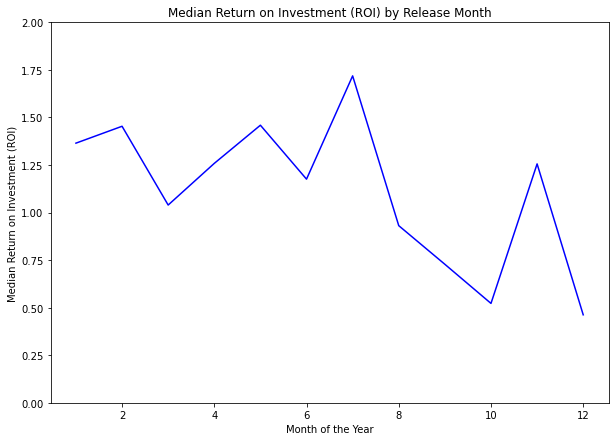

In [35]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Median Return on Investment (ROI) by Release Month')
ax.set_ylabel('Median Return on Investment (ROI)')
ax.set_ylim(0, 2)
ax.set_xlabel('Month of the Year')

sns.lineplot(
    x=df_pivot.index, 
    y=df_pivot['roi'],
    color='blue'
);

---

## Conclusion and Recommendations